# VAE

In [ ]:
def splitmusigma(h, dim = -1):
  m, h = torch.split(h, h.size(dim) // 2, dim=dim)
  v = F.softplus(h) + 1e-8
  return m, v

def kl_normal(qm, qv, pm, pv):
    element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
    kl = element_wise.sum(-1)
    return kl

bce = torch.nn.BCEWithLogitsLoss(reduction='none')
def log_bernoulli_with_logits(x, logits):
    log_prob = -bce(input=logits, target=x).sum(-1)
    return log_prob

def sample_gaussian(m, v):
    eps = torch.normal(mean = 0, std = torch.ones(v.shape))
    z = m + eps * torch.sqrt(v)
    return z

class VAE(nn.Module):
  def __init__(self, n_hidden):
        super().__init__()
        self.name = name
        self.z_dim = z_dim
       
        self.encodenet = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.ELU(),
            nn.Linear(n_hidden, 2)
        )

        self.decodenet = nn.Sequential(
            nn.Linear(2, n_hidden),
            nn.ELU(),
            nn.Linear(n_hidden, 1)
        )

        self.z_prior_m = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
        self.z_prior_v = torch.nn.Parameter(torch.ones(1), requires_grad=False)
        self.z_prior = (self.z_prior_m, self.z_prior_v)
    
  def encode(self, x, y = None):
        xy = x if y is None else torch.cat((x, y), dim=1)
        h = self.net(xy)
        m, v = splitmusigma(h, dim=1)
        return m, v

  def decode(self, z, y=None):
        zy = z if y is None else torch.cat((z, y), dim=1)
        return self.decodenet(zy)

  def loss(self, x):
        st = self.encode(x)
        kl = kl_normal(st[0], st[1], self.z_prior_m, self.z_prior_v)
        rec = -log_bernoulli_with_logits(x, self.decode(sample_gaussian(st[0], st[1])))
        nelbo = (kl + rec).mean()
        return nelbo

# TOP

In [ ]:
! git clone https://github.com/authors-1901-10912/A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms.git

Cloning into 'A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms'...
remote: Enumerating objects: 51, done.
remote: Total 51 (delta 0), reused 0 (delta 0), pack-reused 51
Unpacking objects: 100% (51/51), done.


In [ ]:
! git pull

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!ln -s A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms gitcode

In [ ]:
!ls

A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms
gitcode
sample_data


In [ ]:
!pip install -r gitcode/requirements.txt

     |████████████████████████████████| 591.8MB 17kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.0.0 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101


In [ ]:
% cd gitcode

/content/A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms


In [ ]:
!ln -s ../A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms/notebooks/bivariate-continuous-multimodal/ bcm

In [ ]:
! ls 

# ! pip install .

bcm	causal_meta  notebooks	requirements.txt
causal	__init__.py  README.md	run.py


In [ ]:
import sys
# sys.path.append('../..')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from scipy import interpolate

import random
import tqdm
from copy import deepcopy
from argparse import Namespace
import warnings

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
# from causal_meta.modules import networks as nets
from causal_meta.utils.data_utils import RandomSplineSCM

import causal_meta.utils.train_utils as tu
# from bcm.encoder import Rotor
from causal_meta.modules.mdn import MDN, GMM, mdn_nll
from causal_meta.modules.gmm import GaussianMixture

In [ ]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt

from causal_meta.modules.mdn import mdn_nll
from causal_meta.utils.data_utils import RandomSplineSCM
from causal_meta.utils.train_utils import train_nll, make_alpha, train_alpha
from bcm.models import mdn, gmm, auc_transfer_metric
from argparse import Namespace

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FCMMDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians = 1):
        super(FCMMDN, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(2, n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)

    def forward(self, x, z):
        y = torch.cat([x, z], dim=-1)
        z_h = self.z_h(y)
        pi = F.softmax(self.z_pi(z_h), -1)
        mu = self.z_mu(z_h)
        sigma = torch.exp(self.z_sigma(z_h))
        return pi, mu, sigma

In [ ]:
SEED = 91023
torch.manual_seed(SEED)
np.random.seed(SEED)

# Boilerplate

In [ ]:
def normal(mean, std, N): 
    return torch.normal(torch.ones(N).mul_(mean), torch.ones(N).mul_(std)).view(-1, 1)

In [ ]:
# opt = Namespace()
# # Model
# opt.CAPACITY = 32
# opt.NUM_COMPONENTS = 10
# opt.GMM_NUM_COMPONENTS = 10
# # Training
# opt.LR = 0.001
# opt.NUM_ITER = 3000
# opt.CUDA = False
# opt.REC_FREQ = 10
# # Meta
# opt.ALPHA_LR = 0.1
# opt.ALPHA_NUM_ITER = 500
# opt.FINETUNE_LR = 0.001
# opt.FINETUNE_NUM_ITER = 10
# opt.PARAM_DISTRY = lambda mean: normal(mean, 2, opt.NUM_SAMPLES)
# opt.PARAM_SAMPLER = lambda: np.random.uniform(-4, 4)
# # Sampling 
# opt.NUM_SAMPLES = 1000
# opt.TRAIN_DISTRY = lambda: normal(0, 2, opt.NUM_SAMPLES)
# opt.TRANS_DISTRY = lambda: normal(random.randint(-4, 4), 2, opt.NUM_SAMPLES)

opt = Namespace()

# Model
opt.CAPACITY = 32
opt.NUM_COMPONENTS = 10
# opt.GMM_NUM_COMPONENTS = 10
opt.GMM_NUM_COMPONENTS = 10


# Training
opt.LR = 0.01
opt.NUM_ITER = 500
opt.NUM_META_ITER = 1000
opt.ALPHA_LR = 0.01
opt.ALPHA_NUM_ITER = 1000
opt.CUDA = False
opt.REC_FREQ = 10
opt.ALPHA_INIT = 0.
opt.USE_BASELINE = True

# Fine tuning
opt.FINETUNE_NUM_ITER = 5
opt.FINETUNE_LR = 0.001
opt.EM_ITERS = 500

# Sampling 
opt.NUM_SAMPLES = 1000
opt.TRAIN_DISTRY = lambda: normal(0, 2, opt.NUM_SAMPLES)
opt.TRANS_DISTRY = lambda: normal(np.random.uniform(-4, 4), 
                                  2, opt.NUM_SAMPLES)

opt.PARAM_DISTRY = lambda mean: normal(mean, 2, opt.NUM_SAMPLES)
opt.PARAM_SAMPLER = lambda: np.random.uniform(-4, 4)
opt.ALPHA_NUM_ITER = 500

# Encoder
opt.DECODER_DEFAULT = -float(0.5 * np.pi/2)

In [ ]:
scm = RandomSplineSCM(False, True, 8, 10, 3, range_scale=1.)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from causal_meta.utils.torch_utils import logsumexp
from tqdm import tnrange, tqdm_notebook, notebook
from argparse import Namespace
from copy import deepcopy


def train_nll(opt, model, scm, train_distr_fn, polarity='X2Y', loss_fn=nn.MSELoss(),
              decoder=None, encoder=None):
    optim = torch.optim.Adam(model.parameters(), lr=opt.LR)
    if opt.CUDA:
        model = model.cuda()
        if encoder is not None: 
            encoder = encoder.cuda()
        if decoder is not None: 
            decoder = decoder.cuda()
    frames = []
    for iter_num in tnrange(opt.NUM_ITER, leave=False):
        # Generate samples from the training distry
        X = train_distr_fn()
        with torch.no_grad():
            Y = scm(X)
        if opt.CUDA:
            X, Y = X.cuda(), Y.cuda()
        with torch.no_grad():
            if decoder is not None:
                # X and Y are sampled from the underlying distribution.
                # We apply a secret random transformation to the true latent
                # variables to obtain the raw input
                X, Y = decoder(X, Y)
            if encoder is not None:
                # Apply the encoder, meant to "undo" the decoder up to swapping X and Y.
                X, Y = encoder(X, Y)
        # Now, train as usual
        if polarity == 'X2Y':
            inp, tar = X, Y
        elif polarity == 'Y2X':
            inp, tar = Y, X
        else:
            raise ValueError
        if opt.CUDA:
            inp, tar = inp.cuda(), tar.cuda()
        # Train
        out = model(inp, normal(0, 1, X.size()))
        loss = loss_fn(out, tar)
        optim.zero_grad()
        loss.backward()
        optim.step()
        # Append info
        if iter_num % opt.REC_FREQ or iter_num == (opt.NUM_ITER - 1):
            info = Namespace(loss=loss.item(),
                             iter_num=iter_num)
            frames.append(info)
    return frames

def marginal_nll(opt, inp, nll): 
    model_g = gmm(opt)
    if opt.CUDA: 
        model_g = model_g.cuda()
    model_g.fit(inp)
    with torch.no_grad():
        loss_marginal = nll(model_g(inp), inp)
    return loss_marginal

def transfer_tune(opt, model, model_g, inp, tar, nll): 
    model = deepcopy(model)
    optim_model = torch.optim.Adam(model.parameters(), 
                                   opt.FINETUNE_LR)
    loss_marginal = marginal_nll(opt, inp[0], nll).item()
    joint_losses = []
    for iter_num in range(opt.FINETUNE_NUM_ITER): 
        # Train conditional
        prd = model(inp[0], inp[1])
        loss_conditional = nll(prd, tar)
        optim_model.zero_grad()
        loss_conditional.backward()
        optim_model.step()
        joint_losses.append(loss_conditional.item() + loss_marginal)
    # Return losses
    return joint_losses

def auc_transfer_metric(opt, model, model_g, inp, tar, nll):
    # Tune
    losses = transfer_tune(opt, model, model_g, inp, tar, nll)
    # Compute the integral of the loss curve
    return sum(losses)

def train_alpha(opt, model_x2y, model_y2x, model_g2y, model_g2x, alpha, gt_scm, 
                distr, sweep_distr, nll, transfer_metric, mixmode='logmix'):
    # Everyone to CUDA
    if opt.CUDA: 
        model_x2y.cuda()
        model_y2x.cuda()
    alpha_optim = torch.optim.Adam([alpha], lr=opt.ALPHA_LR)
    frames = []
    iterations = tnrange(opt.ALPHA_NUM_ITER, leave=False)
    for iter_num in iterations:
        # Sample parameter for the transfer distribution
        sweep_param = sweep_distr()
        # Sample X from transfer
        zx = normal(0, 1, 1000)
        zy = normal(0, 1, 1000)
        X_gt = distr(sweep_param)
        Y_gt = gt_scm(X_gt)
        with torch.no_grad():
            if opt.CUDA:
                X_gt, Y_gt = X_gt.cuda(), Y_gt.cuda()
        # Evaluate performance
        metric_x2y = transfer_metric(opt, model_x2y, model_g2x, [X_gt, zy], Y_gt, nll)
        metric_y2x = transfer_metric(opt, model_y2x, model_g2y, [Y_gt, zx], X_gt, nll)
        # Estimate gradient
        if mixmode == 'logmix':
            loss_alpha = torch.sigmoid(alpha) * metric_x2y + (1 - torch.sigmoid(alpha)) * metric_y2x
        else:
            log_alpha, log_1_m_alpha = F.logsigmoid(alpha), F.logsigmoid(-alpha)
            as_lse = logsumexp(log_alpha + metric_x2y, log_1_m_alpha + metric_y2x)
            if mixmode == 'logsigp': 
                loss_alpha = as_lse
            elif mixmode == 'sigp':
                loss_alpha = as_lse.exp()
        # Optimize
        alpha_optim.zero_grad()
        loss_alpha.backward()
        alpha_optim.step()
        # Append info
        with torch.no_grad():
            frames.append(Namespace(iter_num=iter_num,
                                    alpha=alpha.item(), 
                                    sig_alpha=torch.sigmoid(alpha).item(), 
                                    metric_x2y=metric_x2y, 
                                    metric_y2x=metric_y2x, 
                                    loss_alpha=loss_alpha.item()))
        iterations.set_postfix(alpha='{0:.4f}'.format(torch.sigmoid(alpha).item()))
    return frames

In [ ]:
# def mdn(opt): 
#     return MDN(opt.CAPACITY, opt.NUM_COMPONENTS)

def mdn(opt): 
    return FCMMDN(opt.CAPACITY, opt.NUM_COMPONENTS)

def gmm(opt): 
    return GaussianMixture(opt.GMM_NUM_COMPONENTS)

In [ ]:
model_x2y = mdn(opt)
frames_x2y = train_nll(opt, model_x2y, scm, opt.TRAIN_DISTRY, polarity='X2Y',
    loss_fn=mdn_nll, decoder=None, encoder=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


In [ ]:
model_y2x = mdn(opt)
frames_y2x = train_nll(opt, model_y2x, scm, opt.TRAIN_DISTRY, polarity='Y2X',
    loss_fn=mdn_nll, decoder=None, encoder=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


In [ ]:
alpha = make_alpha(opt)
alpha_frames = train_alpha(opt, model_x2y, model_y2x, None, None, alpha, scm, 
                           opt.PARAM_DISTRY, opt.PARAM_SAMPLER, mdn_nll,
                           auc_transfer_metric, mixmode='logsigp')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


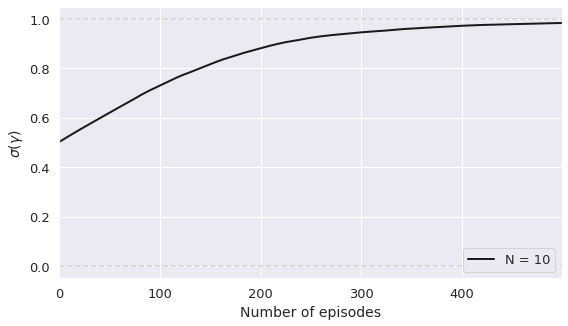

In [ ]:
alphas = np.asarray([frame.sig_alpha for frame in alpha_frames])

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(1, c='lightgray', ls='--')
ax.axhline(0, c='lightgray', ls='--')
ax.plot(alphas, lw=2, color='k', label='N = {0}'.format(10))

ax.set_xlim([0, opt.ALPHA_NUM_ITER - 1])
ax.set_xlabel('Number of episodes', fontsize=14)
ax.set_ylabel(r'$\sigma(\gamma)$', fontsize=14)
ax.legend(loc=4, prop={'size': 13})

plt.show()